### Analysis wind information and pm10

In [1]:
# GET ALL THE JSONS INTO ONE DATAFRAME
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import glob

#### Get all the pm10 files and keep columns which contain pm10

In [2]:
# Set the search path for files (assuming the directory is relative to the current script)
file_path_mc124 = os.path.join("mc124_data", "*.json")
files = glob.glob(file_path_mc124)

# Create empty list to store dataframes
li_all_files = []

# Loop through list of files and read each one into a dataframe and append to list
for f in files:
    # Read in json
    temp_df = pd.read_json(f)
    # Append df to list
    li_all_files.append(temp_df)

# Optionally concatenate all dataframes into one if needed
if li_all_files:
    combined_df = pd.concat(li_all_files)
    print(f'Combined dataframe shape: {combined_df.shape}')
else:
    print('No dataframes were created.')

Combined dataframe shape: (542555, 6)


In [3]:
# FILTER BY pm10 AND ONLY KEEP THE DATETIME AND VALUE FEATURE SINCE THE REST ARE CONSTANT INFORMATION (station, core, component, period)
df_pm10 = combined_df[(combined_df['core'] == 'pm10')]
df_pm10_reduced = df_pm10[['datetime', 'value']]
df_pm10_reduced = df_pm10_reduced.rename(columns={'value': 'pm10'})
df_pm10_reduced.sample(3)

,datetime,pm10
1705,2017-10-17T18:00:00+02:00,55.0
2410,2018-12-11 21:00:00+01:00,9.0
764,2016-10-24T00:00:00+02:00,26.0


In [4]:
# CUT OFF THE TIMEZONE INFORMATION FROM THE DATETIME TO AVOID CONVERSION ISSUES DUE TO TIME CHANGE IN MARCH AND OCTOBER
df_pm10_reduced.loc[:, 'datetime'] = df_pm10_reduced['datetime'].astype(str).str.slice(0, 19)
#df_pm10_reduced.loc[:, 'datetime'] = pd.to_datetime(df_pm10_reduced['datetime'], format='mixed')
df_pm10_reduced['datetime'] = pd.to_datetime(df_pm10_reduced['datetime'], format='mixed')
df_pm10_reduced.loc[:, 'datetime'] = df_pm10_reduced['datetime'].dt.tz_localize(None)
df_pm10_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72314 entries, 0 to 3650
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  72314 non-null  datetime64[ns]
 1   pm10      71471 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 MB


In [5]:
df_pm10_reduced.sample(5)

,datetime,pm10
2365,2024-05-11 17:00:00,14.0
2610,2017-04-09 05:00:00,20.0
15,2018-10-31 20:00:00,24.0
40,2018-08-31 15:00:00,16.0
2170,2023-05-13 21:00:00,19.0


#### Load wind data and filter for wind speed and wind direction

##### Erklärung Windrichtung  
https://www.dwd.de/DE/service/lexikon/Functions/glossar.html?lv3=103182&lv2=102936  
Die Windrichtung wird bestimmt nach dem Polarwinkel (Azimut). Zur Richtungsangabe benutzt man die 360 Grad Skala des Kreises.   
Alle Richtungsangaben in Grad sind recht weisend auf geografisch Nord bezogen, d.h.
Ost  =  90 Grad,  
Süd  =  180 Grad,  
West =  270 Grad,   
Nord =  360 Grad.  

In [6]:
file_path_berlin = os.path.join("..", "winddaten_berlin","produkt_wind_399_akt.txt")# join because different os use either \ or / as file path separators
weather_station = pd.read_csv(file_path_berlin, names=['stations_id','date','quality_level','structure_version', 'wind_speed', 'wind_direction', 'eor'], skiprows=1, sep=';') 
# TODO rename names
weather_station.sample(5)

,stations_id,date,quality_level,structure_version,wind_speed,wind_direction,eor
93,399,2015082400,2,0,14.5,140,eor
54215,399,2022051908,2,0,5.4,220,eor
42902,399,2021012617,2,0,10.3,280,eor
14634,399,2017042211,2,0,12.2,290,eor
38862,399,2020081109,2,0,5.9,80,eor


In [7]:
# Convert the 'dates' column to datetime and store it in a new column 'datetime'
weather_station.loc[:,'datetime'] = pd.to_datetime(weather_station['date'], format='%Y%m%d%H')
weather_station.sample(5)

,stations_id,date,quality_level,structure_version,wind_speed,wind_direction,eor,datetime
24714,399,2018061808,2,0,2.0,270,eor,2018-06-18 08:00:00
14866,399,2017050203,2,0,16.2,80,eor,2017-05-02 03:00:00
5576,399,2016040910,2,0,2.9,40,eor,2016-04-09 10:00:00
2114,399,2015111613,2,0,14.4,250,eor,2015-11-16 13:00:00
2193,399,2015111920,2,0,14.9,260,eor,2015-11-19 20:00:00


In [8]:
# Filter necessary rows
weather_station_reduced = weather_station[['datetime','wind_speed','wind_direction']]
weather_station_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65861 entries, 0 to 65860
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        65861 non-null  datetime64[ns]
 1   wind_speed      65861 non-null  float64       
 2   wind_direction  65861 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.5 MB


In [9]:
weather_station_reduced.sample(5)

,datetime,wind_speed,wind_direction
13759,2017-03-17 00:00:00,11.9,210
47989,2021-09-01 22:00:00,7.7,330
48562,2021-09-25 19:00:00,4.5,250
3137,2015-12-29 19:00:00,17.1,120
23045,2018-04-09 19:00:00,6.4,90


#### Merge df_pm10_reduced and weather_station_reduced based on datetime/DATETIME

In [10]:
df_merged = pd.merge(df_pm10_reduced, weather_station_reduced, on='datetime', how='outer')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77254 entries, 0 to 77253
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        77254 non-null  datetime64[ns]
 1   pm10            71471 non-null  float64       
 2   wind_speed      65861 non-null  float64       
 3   wind_direction  65861 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.4 MB


In [11]:
df_merged.sample(5)

,datetime,pm10,wind_speed,wind_direction
42895,2021-01-11 11:00:00,19.0,12.1,230.0
20328,2018-06-05 20:00:00,27.0,11.3,30.0
46163,2021-06-25 06:00:00,23.0,3.5,300.0
70888,2024-04-29 22:00:00,18.0,13.0,60.0
2931,2016-07-31 19:00:00,15.0,4.2,360.0


In [12]:
#Deleting all rows before March 2016 since useful pm10 data starts in March 2016
start_date = '2016-03-01'
start_date = pd.Timestamp(start_date)
df_filtered = df_merged[df_merged['datetime'] >= start_date]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72624 entries, 0 to 77253
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        72624 non-null  datetime64[ns]
 1   pm10            71471 non-null  float64       
 2   wind_speed      61231 non-null  float64       
 3   wind_direction  61231 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.8 MB


In [13]:
df_filtered.head()

,datetime,pm10,wind_speed,wind_direction
0,2016-03-31 23:00:00,16.0,8.3,40.0
1,2016-03-31 22:00:00,22.0,8.4,40.0
2,2016-03-31 21:00:00,22.0,7.5,40.0
3,2016-03-31 20:00:00,24.0,9.1,60.0
4,2016-03-31 19:00:00,21.0,8.6,40.0


#### Create heatmap and scatter plots to visualise relationship between pm10 wind_speed and wind_direction

In [14]:
# Create correlation matrix
correlation_matrix = df_merged.set_index('datetime').corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                    pm10  wind_speed  wind_direction
pm10            1.000000   -0.225838       -0.117976
wind_speed     -0.225838    1.000000        0.137632
wind_direction -0.117976    0.137632        1.000000


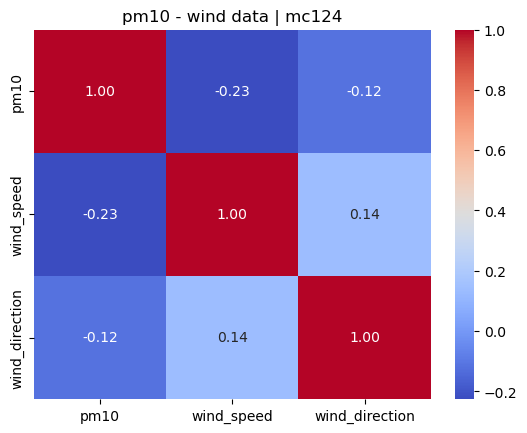

In [22]:
# show heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("pm10 - wind data | mc124")
plt.show()